## SPEECH EMOTION RECOGNITION (SER)

Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion

**Motivation**
* SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

* It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

In [1]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
CREMA = "/kaggle/input/cremad/AudioWAV/"

In [3]:
## Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_happy        60
male_fear         60
male_disgust      60
male_angry        60
male_surprise     60
male_sad          60
Name: labels, dtype: int64

In [4]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_sad            96
male_fear           96
male_happy          96
male_disgust        96
male_angry          96
male_surprise       96
female_surprise     96
female_disgust      96
female_fear         96
female_sad          96
female_happy        96
female_angry        96
Name: labels, dtype: int64

In [5]:
dir_list = os.listdir(TESS)
dir_list.sort()
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_fear        400
female_surprise    400
female_sad         400
female_angry       400
female_disgust     400
female_happy       400
female_neutral     400
Name: labels, dtype: int64

In [6]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [7]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        671
male_disgust      671
male_fear         671
male_happy        671
male_sad          671
female_angry      600
female_disgust    600
female_fear       600
female_happy      600
female_sad        600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

In [8]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_disgust     1096
female_fear        1096
female_sad         1096
female_happy       1096
female_angry       1096
female_neutral     1056
male_neutral        839
male_happy          827
male_fear           827
male_disgust        827
male_angry          827
male_sad            827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64


In [9]:
ref = pd.read_csv("/kaggle/working/Data_path.csv")
ref.head()

,labels,source,path
0,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
1,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
2,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
3,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
4,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


In [10]:
import seaborn as sns

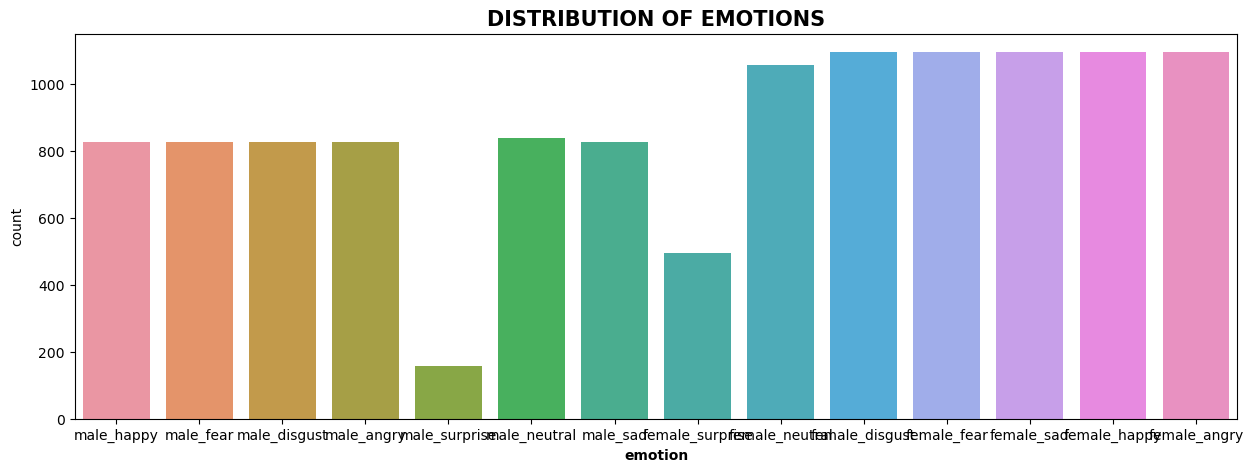

In [11]:
plt.figure(figsize = (15,5))
sns.countplot(data = df,x= 'labels')
plt.title('DISTRIBUTION OF EMOTIONS',fontweight = 'bold',fontsize = 15)
plt.xlabel('emotion',fontweight = 'bold');

In [12]:
def audio_visual(path,labels) :
    data , sample_rate = librosa.load(path)
    plt.figure(figsize = (10,5))
    plt.title(f'Waveplot for audio with {emotion} emotions')
    waveshow(data,sample_rate)
    plt.show()
    
    return ipd.Audio(path)

## FEATURE EXTRACTION
 the data provided from audio cannot be understood by the models directly, so we need to convert them into an understandable format for which feature extraction is used. The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

Looking at the waveplots above seems clear (from an eye test) that the waveform itself may not necessarily yield clear class identifying information. Infact they look quite similar.

It turns out one of the best tool to feature extract from audio waveforms ( and digital signal in general) is Mel Frequency Cepstral Coefficents (MFCCs). 

## Data Augmentation

In [13]:
def feature_extraction(file) :
  mfcc_features = librosa.feature.mfcc(y=file,sr = sample_rate,n_mfcc = 40)
  mfcc_scaled_feature = np.mean(mfcc_features.T,axis = 0)
  return mfcc_scaled_feature

  # NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
#higher speed
def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data, speed_factor)
# lower speed
def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data, speed_factor)

In [14]:
# Trying different functions above
path = np.array(ref['path'])[471]
data, sample_rate = librosa.load(path)

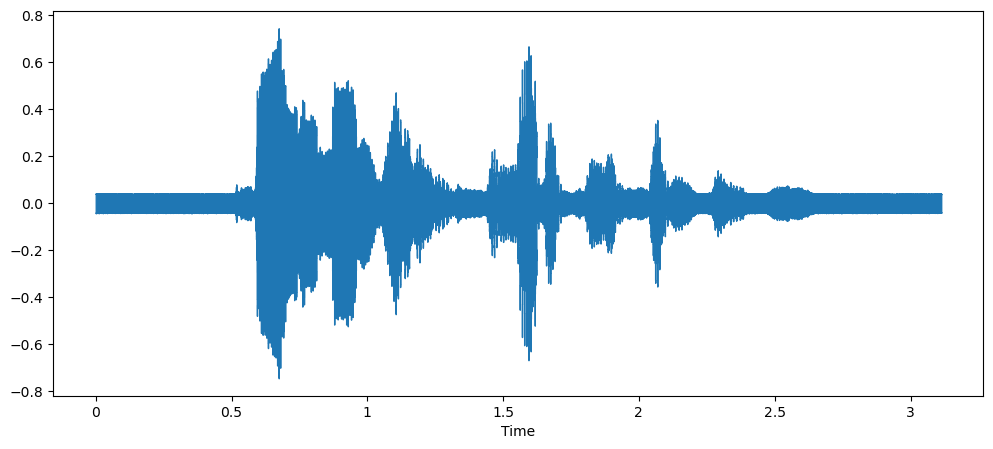

In [15]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

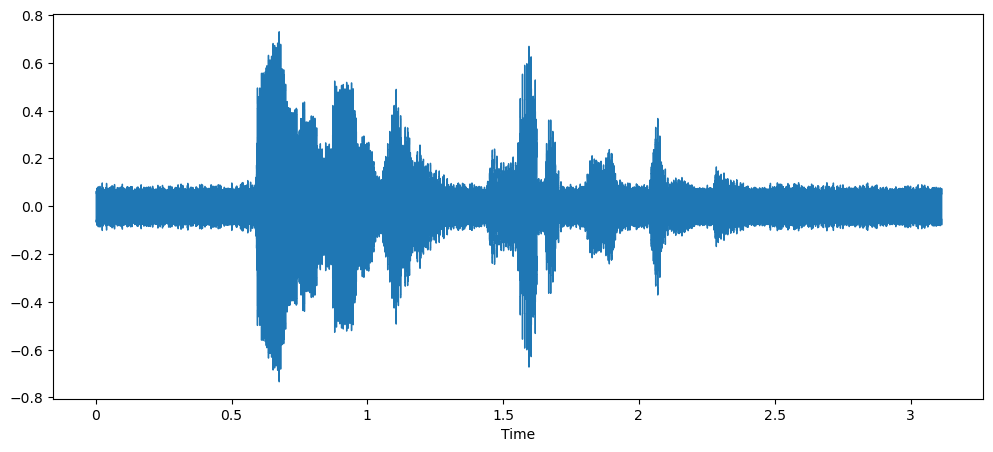

In [16]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

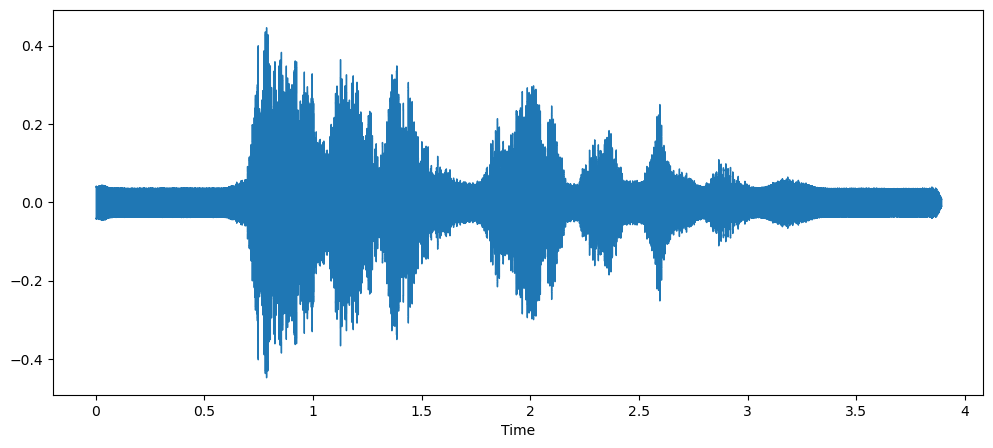

In [17]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

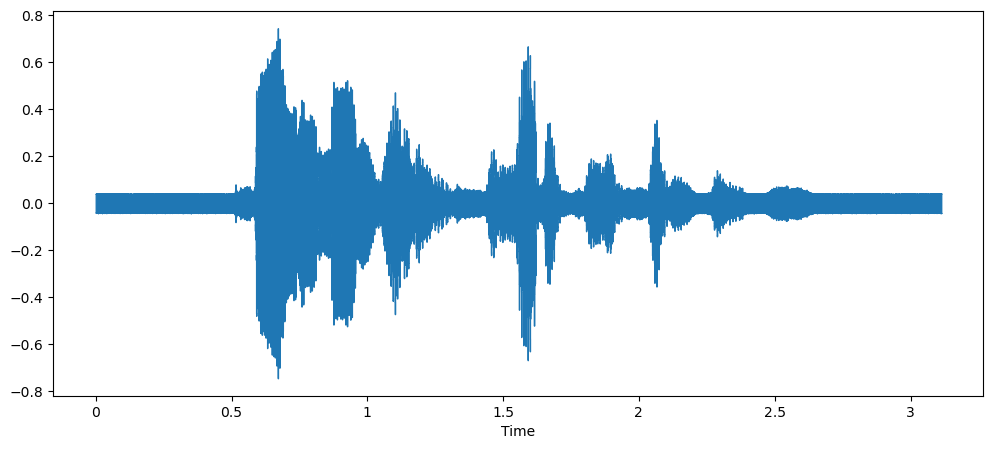

In [18]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

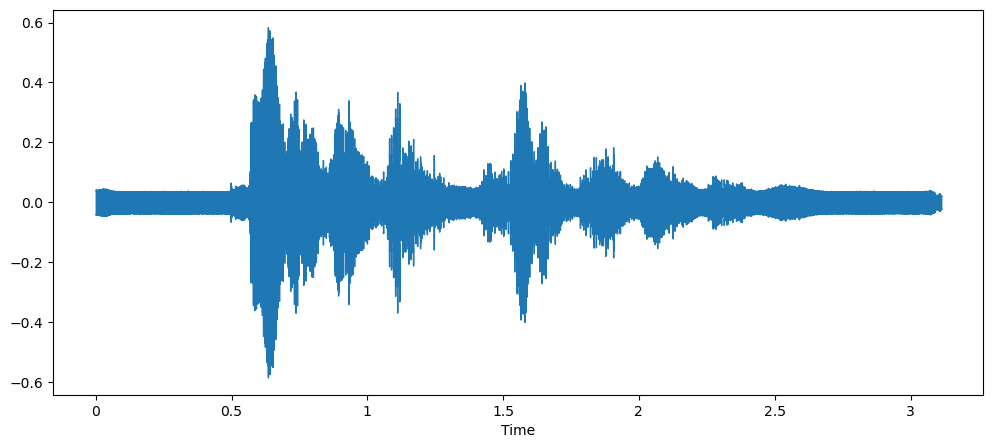

In [19]:
# AUDIO WITH PITCH
x = pitch(data, sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

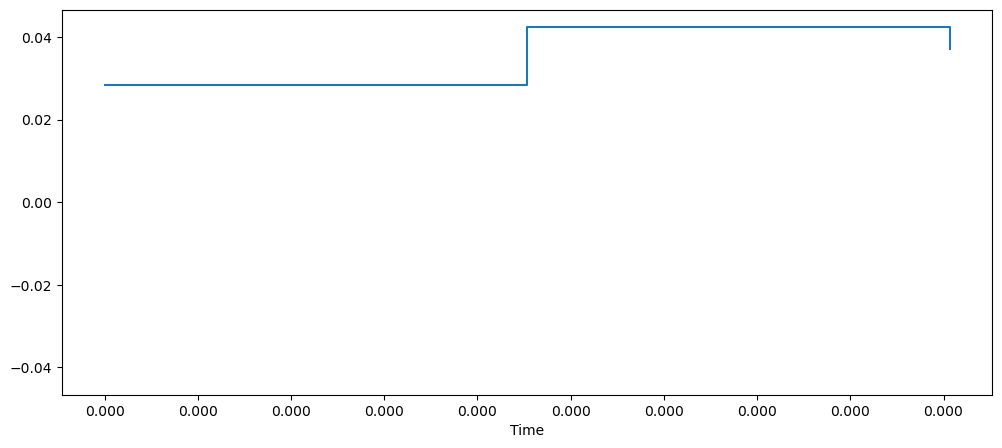

In [20]:
# AUDIO WITH high speed
x = higher_speed(data, sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

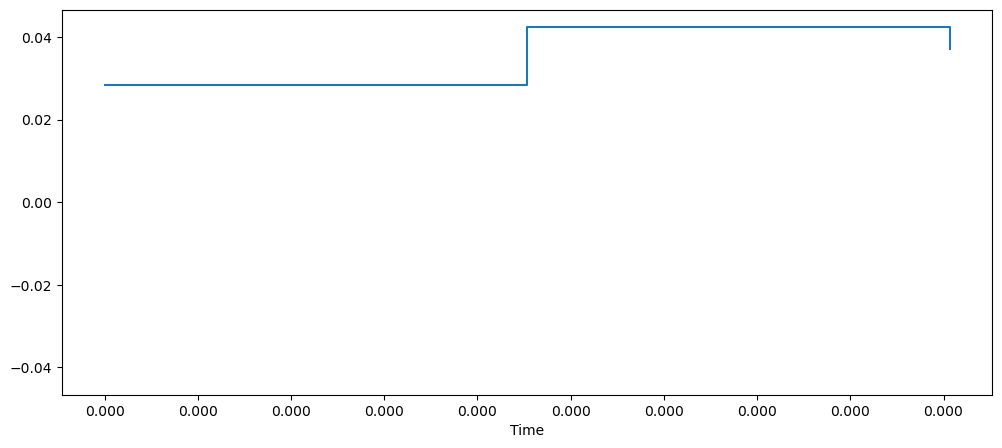

In [21]:
x = lower_speed(data, sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

In [22]:
def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feature_extraction(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feature_extraction(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feature_extraction(data_stretch_pitch)
    result = np.vstack((result, res3))
    # data with high speed
    high_speed = higher_speed(data)
    res4 = feature_extraction(high_speed)
    result = np.vstack((result,res4))
    # data with low speed
    low_speed = lower_speed(data)
    res5 = feature_extraction(high_speed)
    result = np.vstack((result,res5))
    return result


In [23]:
from tqdm import tqdm
X, Y = [], []

for path,emotion in tqdm(zip(ref['path'],ref['labels'])) :
   feature = get_feat(path)
   for ele in feature :
       X.append(ele)
       Y.append(emotion)

12162it [45:08,  4.49it/s]


In [24]:
Emotions = pd.DataFrame(X)
Emotions['labels'] = Y
Emotions.to_csv('emotion.csv', index=False)

In [25]:
import pandas as pd

In [26]:
Emotions= pd.read_csv('/kaggle/input/emotion/emotion (1).csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,labels
0,-258.990326,132.193741,5.314349,21.521330,-24.357752,-2.237025,-24.086287,-9.530801,-20.967497,-4.285268,...,-0.953883,1.146237,1.829600,2.893938,1.310414,1.626812,2.758013,4.257873,3.918041,male_happy
1,-258.667152,132.047682,5.236842,21.529129,-24.335813,-2.170860,-24.135509,-9.465332,-20.959675,-4.215839,...,-0.906946,1.140402,1.826270,2.867984,1.350153,1.576485,2.766849,4.228887,3.915566,male_happy
2,-301.181824,128.659897,4.380285,9.940308,-23.697367,-7.601327,-25.921268,-13.189119,-19.924520,-0.300373,...,3.321182,3.191138,3.419615,3.112536,1.654553,3.749860,5.546700,4.269989,1.401541,male_happy
3,-274.135437,142.405472,-2.322214,21.200804,-27.737436,-1.496183,-26.762552,-10.112954,-21.643480,-3.658734,...,-1.149690,1.346368,2.298612,3.353943,1.820001,2.129130,2.610373,4.910376,4.944275,male_happy
4,-274.135437,142.405472,-2.322214,21.200804,-27.737436,-1.496183,-26.762552,-10.112954,-21.643480,-3.658734,...,-1.149690,1.346368,2.298612,3.353943,1.820001,2.129130,2.610373,4.910376,4.944275,male_happy


## DATA PREPROCESSING

In [27]:
X = Emotions.drop('labels',axis = 1)
Y = Emotions['labels']

In [28]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [29]:
# since it is a multiclass classifier, i will perform onehotencoding
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [30]:
X.shape

(60810, 40)

In [31]:
Y.shape

(60810, 14)

In [32]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,shuffle = True)

x_train.shape,y_train.shape,x_test.shape,y_test.shape

((48648, 40), (48648, 14), (12162, 40), (12162, 14))

In [33]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((48648, 40), (48648, 14), (12162, 40), (12162, 14))

In [34]:
# decision tree 
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)

DecisionTreeClassifier()

In [35]:
y_pred = clf.predict(x_test)

In [36]:
print(f'the training score for decision tree is {clf.score(x_train,y_train)}')

the training score for decision tree is 0.9996094392369677


In [37]:
print(f'the test score for decision tree is {clf.score(x_test,y_test)}')

the test score for decision tree is 0.6240749876665023


After Using the decision tree model in our dataset then the model goes in overfitting he gave accuracy around .41

## MLP CLASSIFIER

In [38]:
from sklearn.neural_network import MLPClassifier
clf2=MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)
clf2.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=270, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=400)

In [39]:
print(f"Training set score: {(clf2.score(x_train, y_train))}")
print(f"Test set score: {(clf2.score(x_test, y_test))}")

Training set score: 0.777359809241901
Test set score: 0.6332017760236803


## CNN

In [40]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D,Dense,AveragePooling1D,Dropout,add,BatchNormalization,LSTM,Flatten,MaxPooling1D,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from keras.activations import relu, softmax
from sklearn.metrics import confusion_matrix,classification_report

In [41]:

#CNN
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((48648, 40, 1), (48648, 14), (12162, 40, 1), (12162, 14))

In [42]:
my_model=Sequential()
my_model.add(Conv1D(256, kernel_size=7, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
my_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
my_model.add(BatchNormalization())

my_model.add(Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu'))
my_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
my_model.add(BatchNormalization())

my_model.add(Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu'))
my_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
my_model.add(BatchNormalization())


my_model.add(Conv1D(64, kernel_size=7, strides=1, padding='same', activation='relu'))
my_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))
        
my_model.add(Flatten())
my_model.add(Dense(units=32, activation='relu'))
my_model.add(Dropout(0.5))

my_model.add(Dense(units=14, activation='softmax'))
my_model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 256)           2048      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 256)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 20, 256)          1024      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 128)           229504    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 128)          0         
 1D)                                                             
                                                        

In [43]:
history = my_model.fit(x_traincnn, y_train, batch_size=32, epochs=50, validation_data=(x_testcnn, y_test))

Epoch 1/50
1521/1521 [==============================] - 56s 36ms/step - loss: 1.9283 - accuracy: 0.3378 - val_loss: 1.3550 - val_accuracy: 0.5053
Epoch 2/50
1521/1521 [==============================] - 54s 36ms/step - loss: 1.4758 - accuracy: 0.4626 - val_loss: 1.2180 - val_accuracy: 0.5414
Epoch 3/50
1521/1521 [==============================] - 55s 36ms/step - loss: 1.3493 - accuracy: 0.5022 - val_loss: 1.1341 - val_accuracy: 0.5729
Epoch 4/50
1521/1521 [==============================] - 53s 35ms/step - loss: 1.2559 - accuracy: 0.5314 - val_loss: 1.0775 - val_accuracy: 0.5870
Epoch 5/50
1521/1521 [==============================] - 53s 35ms/step - loss: 1.1930 - accuracy: 0.5505 - val_loss: 1.0450 - val_accuracy: 0.6071
Epoch 6/50
1521/1521 [==============================] - 53s 35ms/step - loss: 1.1303 - accuracy: 0.5742 - val_loss: 0.9855 - val_accuracy: 0.6230
Epoch 7/50
1521/1521 [==============================] - 54s 35ms/step - loss: 1.0734 - accuracy: 0.5947 - val_loss: 0.9315 -

In [44]:
print("Accuracy of our model on test data : " , round(my_model.evaluate(x_testcnn,y_test)[1],2)*100 , "%")



381/381 [==============================] - 3s 7ms/step - loss: 0.7423 - accuracy: 0.8259
Accuracy of our model on test data :  83.0 %


In [45]:
model_name = 'emotion_model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)   # adds file in folder
my_model.save(model_path)
print('Save model and weights at %s' % model_path)
model_json = my_model.to_json()
with open('model_json.json', 'w') as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/emotion_model.h5


ValueError: x and y must have same first dimension, but have shapes (32,) and (50,)

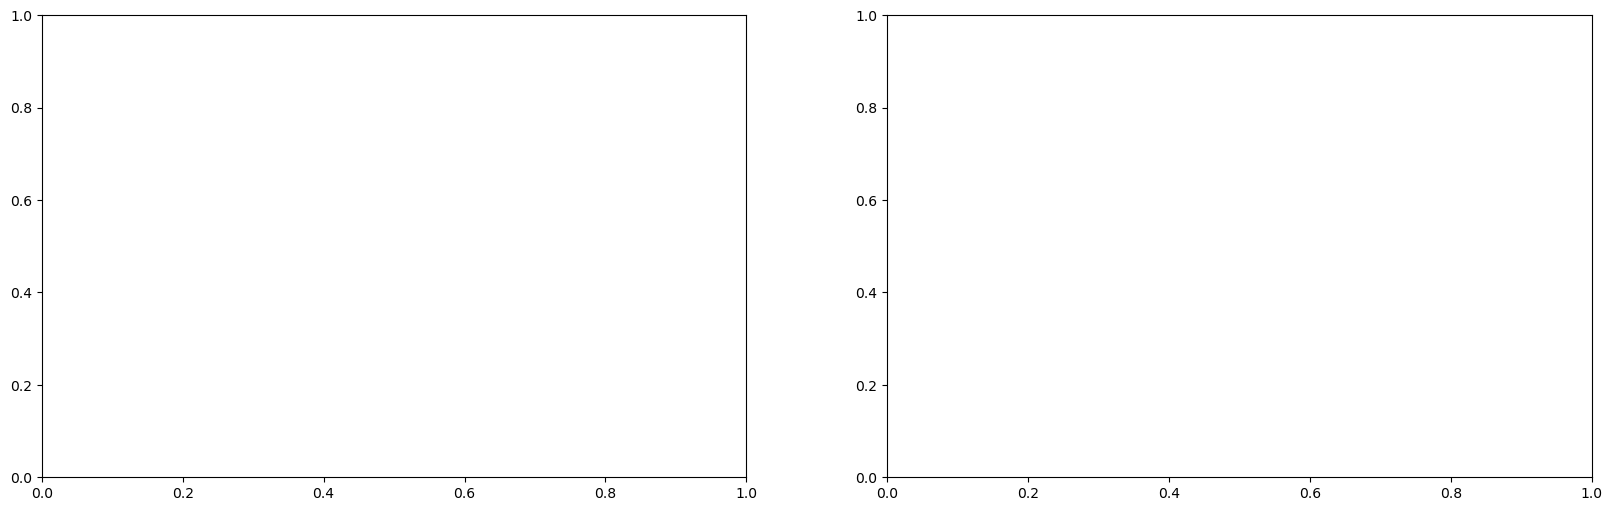

In [46]:
epochs = [i for i in range(32)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

## Confusion Matrix

In [ ]:
# predicting on test data.
pred_test = my_model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

In [ ]:
df

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

Classification report

In [ ]:
print(classification_report(y_test, y_pred))

* Our has a good precision and recall score across all labels
* We overall achieved 82% accuracy on our test data and its very decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.